# Portfolio Insurance Simulation

This notebook simulates a **portfolio insurance strategy** using **put options** on the S&P 500 index.

### Objectives
- Model an investment portfolio exposed to market risk  
- Introduce protective puts to limit downside losses  
- Compare unhedged vs. hedged portfolio performance  
- Visualize the tradeoff between protection cost and upside participation

### Steps
1. **Market** — Fetch and provide historical S&P 500 price data  
2. **Option** — Model put option payoff and pricing  
3. **Portfolio** — Track asset value, cash, and option holdings  
4. **Strategy** — Define when/how to buy protective puts  
5. **SimulationEngine** — Run the backtest over time

We'll use `yfinance` to pull market data and a simple simulation loop to evolve portfolio value over time.

In [5]:
# If you haven't installed yahoo finance
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [6]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

## Step 1: Modeling Market
In this step, we create the **Market** class, which serves as the foundation of our simulation environment. The market model provides the external “world” in which our portfolio operates. It defines how prices evolve over time and lets the simulation access historical data for backtesting.

Below, we define the Market class that automatically downloads data for the chosen ticker (default: **S&P 500**, ticker `^GSPC`) from **2018–2025**, and computes daily returns used by the simulation.


In [ ]:
class Market:
    """
    Fetches and stores market data (e.g., S&P 500 prices) using Yahoo Finance.
    Provides methods to get current prices and returns over time.
    """

    def __init__(self, ticker="^GSPC", start="2018-01-01", end="2025-01-01"):
        self.ticker = (
            ticker  # The Yahoo Finance ticker (default is "^GSPC" for S&P 500)
        )
        self.data = yf.download(ticker, start=start, end=end, auto_adjust=False)
        # print(self.data)

        # computes percentage change in adjusted closing prices between consecutive days
        self.data["Returns"] = self.data["Close"].pct_change().fillna(0)

    def get_price(self, date):
        # Return adjusted close price for a given date
        return self.data.loc[date, "Close"]

    def get_returns(self):
        # Return the full time series of daily returns
        return self.data["Returns"]

Quick Overview

In [20]:
market = Market()
market.data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Returns
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,,
2018-01-02,2695.810059,2695.810059,2695.889893,2682.360107,2683.729980,3397430000,0.000000
2018-01-03,2713.060059,2713.060059,2714.370117,2697.770020,2697.850098,3544030000,0.006399
2018-01-04,2723.989990,2723.989990,2729.290039,2719.070068,2719.310059,3697340000,0.004029
2018-01-05,2743.149902,2743.149902,2743.449951,2727.919922,2731.330078,3239280000,0.007034
2018-01-08,2747.709961,2747.709961,2748.510010,2737.600098,2742.669922,3246160000,0.001662


## Step 2: Modeling Put Options
Now that we have market data from the `Market` class, the next step is to define how **put options** behave.

A **put option** gives the holder the right (but not the obligation) to sell an asset at a predetermined price (the *strike price*) on or before a specific date (the *expiry*). In the context of portfolio insurance, these puts act like **insurance policies** (they gain value when the market declines.)

We’ll start simple: we assume each option’s value equals its intrinsic value (no time value or volatility modeling yet). This will let us simulate the mechanics of protection before adding pricing models later.

In [36]:
class Option:
    """
    Attributes:
        strike (float): Strike price (K)
        premium (float): Option cost (C)
        expiry (datetime): Expiration date
        quantity (int): Number of contracts
    """

    def __init__(self, strike, premium, expiry, quantity=1):
        self.strike = strike
        self.premium = premium
        self.expiry = expiry
        self.quantity = quantity  # positive for long (buy), negative for short (sell)

    def payoff(self, current_price):
        """
        Returns the option's payoff if held until expiry.
        For a put: payoff = max(K - S, 0) * quantity
        """
        return max(self.strike - current_price, 0) * self.quantity

    def value(self, current_price, current_date):
        """
        For simplicity, assume the option value is equal to its intrinsic value
        until we add a pricing model (no time value yet).
        If expired, value = 0 (we'll count payoff separately).
        """
        curr_date = pd.Timestamp(current_date)
        expiry_date = pd.Timestamp(self.expiry)

        if curr_date >= expiry_date:
            return 0.0
        return max(self.strike - float(current_price), 0.0) * self.quantity

    def total_cost(self):
        """Return the total cost (premium * quantity)."""
        return self.premium * self.quantity

Quick Test Example

In [37]:
today = datetime(2023, 1, 1)
expiry = today + timedelta(days=365)

put = Option(strike=4000, premium=150, expiry=expiry)

print("If S&P 500 ends at 4500 → payoff =", put.payoff(4500))
print("If S&P 500 ends at 3500 → payoff =", put.payoff(3500))
print("Option total cost =", put.total_cost())

If S&P 500 ends at 4500 → payoff = 0
If S&P 500 ends at 3500 → payoff = 500
Option total cost = 150


## Step 3: Building the Portfolio Class
With the `Market` and `Option` components in place, we can now build the **Portfolio** class — the core of our simulation framework. This class represents the investor’s overall position, capturing how their wealth evolves as the market moves and as protection strategies are applied.

The portfolio keeps track of:
- The total investment value across all components  
- Changes in equity value as the market fluctuates  
- Adjustments to cash and option holdings when new hedges are purchased  
- Historical records of portfolio value over time for analysis and visualization  

In [ ]:
class Portfolio:
    """
    Portfolio with equity exposure, cash, and put options.

    Attributes:
        initial_value (float): Starting total portfolio value.
        equity_value (float): Current equity (market-exposed) portion.
        cash (float): Uninvested cash (may go negative for premiums).
        beta (float): Market sensitivity (1.0 = market, >1 more volatile).
        options (list[Option]): Currently held put options.
        history (list[dict]): Daily records of portfolio value.
    """

    def __init__(self, initial_value=1_000_000, beta=1.0):
        self.initial_value = initial_value
        self.equity_value = initial_value  # starts fully invested
        self.cash = 0
        self.beta = beta
        self.options = []
        self.history = []

    def buy_put(self, strike, premium, expiry, quantity=1):
        """Buy a put and subtract premium cost from cash."""
        option = Option(strike, premium, expiry, quantity)
        self.options.append(option)
        self.cash -= option.total_cost()

    def update_equity(self, daily_return):
        """Apply daily market return scaled by beta to equity value."""
        self.equity_value *= 1 + daily_return * self.beta

    def total_value(self, current_price, current_date):
        """Total value = equity + cash + sum(option intrinsic values."""
        option_value = sum(
            opt.value(current_price, current_date) for opt in self.options
        )
        return self.equity_value + self.cash + option_value

    def record(self, date, total_value):
        """Store daily portfolio value (for plotting later)."""
        self.history.append({"Date": date, "Value": total_value})

Quick test for Portfolio

In [ ]:
# === Step 1: Initialize Portfolio ===
portfolio = Portfolio(initial_value=1_000_000, beta=1.0)

print("Initial Portfolio State:")
print(f"Equity Value: {portfolio.equity_value}")
print(f"Cash: {portfolio.cash}")
initial_total = portfolio.total_value(
    current_price=4000,
    current_date=datetime(2023, 1, 1),
)
print(f"Total Value: {initial_total}")
print("-" * 60)

# === Step 2: Buy a Put Option (Portfolio Insurance) ===
expiry = datetime(2023, 12, 31)
portfolio.buy_put(strike=4000, premium=150, expiry=expiry, quantity=1)

print("After Buying 1 Put Option:")
print(f"Cash after paying premium: {portfolio.cash}")
print(f"Number of options: {len(portfolio.options)}")
print("-" * 60)

# === Step 3: Simulate Market Drop ===
portfolio.update_equity(daily_return=-0.05)  # Market drops 5%
current_price = 3800
current_date = datetime(2023, 6, 1)
option_value = sum(opt.value(current_price, current_date) for opt in portfolio.options)
total_value = portfolio.total_value(current_price, current_date)

print("After Market Drops 5%:")
print(f"Equity Value: {portfolio.equity_value:.2f}")
print(f"Option Value: {option_value:.2f}")
print(f"Cash: {portfolio.cash:.2f}")
print(f"Total Portfolio Value: {total_value:.2f}")

Initial Portfolio State:
Equity Value: 1000000
Cash: 0
Total Value: 1000000
------------------------------------------------------------
After Buying 1 Put Option:
Cash after paying premium: -150
Number of options: 1
------------------------------------------------------------
After Market Drops 5%:
Equity Value: 950000.00
Option Value: 200.00
Cash: -150.00
Total Portfolio Value: 950050.00


## Step 4 & 5: Building the Strategy and Simulation Engine

Now that our portfolio can hold stocks and put options, we need to simulate how it evolves over time.

We'll define two components:

1. **Strategy:** Determines *when* and *how* to purchase protective put options.

2. **Simulation Engine:** Steps through historical market data (from the `Market` class), updates the portfolio each day, applies the strategy, and records results.

Define a Simple Quaterly Strategy Function: This strategy buys a new put every 90 days, struck 10% below the current price, and costing a fixed 1% of the portfolio’s equity value.

In [ ]:
def quarterly_protective_put_strategy(portfolio, current_price, current_date, params):
    """
    Every hedge_interval days, buy a 10% OTM put expiring in expiry_days.

    Args:
        portfolio (Portfolio): Portfolio instance.
        current_price (float): Latest market price.
        current_date (datetime): Simulation date.
        params (dict): e.g. {'hedge_interval': 90, 'put_cost': 0.01}.
    """
    hedge_interval = params.get("hedge_interval", 90)  # days
    put_cost_ratio = params.get("put_cost", 0.01)  # 1% of portfolio value
    strike_ratio = params.get("strike_ratio", 0.9)  # 10% below market
    expiry_days = params.get("expiry_days", 90)

    # Only buy on scheduled days
    last_action = params.get("last_action")
    if last_action is None or (current_date - last_action).days >= hedge_interval:
        strike = current_price * strike_ratio
        premium = portfolio.equity_value * put_cost_ratio
        expiry = current_date + timedelta(days=expiry_days)
        portfolio.buy_put(strike, premium, expiry, quantity=1)
        params["last_action"] = current_date

Simulation Engine: loops through each trading day, updates equity, applies the strategy, computes portfolio value, and records it.

In [90]:
def run_simulation(market, portfolio, strategy_fn, params):
    """
    Run a daily simulation of portfolio evolution over the market period.
    Automatically handles both 4-arg and 5-arg strategy functions.
    """
    for date, row in market.data.iterrows():
        # Extract scalar values safely
        price = row["Close"]
        if isinstance(price, pd.Series):
            price = price.iloc[0]
        daily_return = row["Returns"]
        if isinstance(daily_return, pd.Series):
            daily_return = daily_return.iloc[0]
        price = float(price)
        daily_return = float(daily_return)

        # Update equity
        portfolio.update_equity(daily_return)

        # Apply strategy (detects if strategy expects 'market' argument)
        import inspect

        args = inspect.signature(strategy_fn).parameters
        if "market" in args:
            strategy_fn(portfolio, price, pd.Timestamp(date), params, market)
        else:
            strategy_fn(portfolio, price, pd.Timestamp(date), params)

        # Record total value
        total = portfolio.total_value(price, pd.Timestamp(date))
        portfolio.record(pd.Timestamp(date), total)

    return pd.DataFrame(portfolio.history)

## Run Simulation
Now we can run a test simulation over historical S&P 500 data:

In [111]:
# Initialize market and portfolio
market = Market(start="2018-01-01", end="2025-01-01")
portfolio = Portfolio(initial_value=1_000_000, beta=1.0)

# Strategy parameters
params = {
    "hedge_interval": 90,  # rebalance every 3 months
    "put_cost": 0.01,  # 3% premium cost
    "strike_ratio": 0.9,  # 10% below market
    "expiry_days": 90,
}

# Run the simulation
results = run_simulation(market, portfolio, quarterly_protective_put_strategy, params)
results.head()

[*********************100%***********************]  1 of 1 completed


,Date,Value
0,2018-01-02,9.900000e+05
1,2018-01-03,9.963988e+05
2,2018-01-04,1.000453e+06
3,2018-01-05,1.007561e+06
4,2018-01-08,1.009252e+06


Now that our simulation engine has produced a time-series of portfolio values,
we can visualize how the **hedged portfolio** (with quarterly put protection)
compares to an **unhedged portfolio** that simply tracks the market.

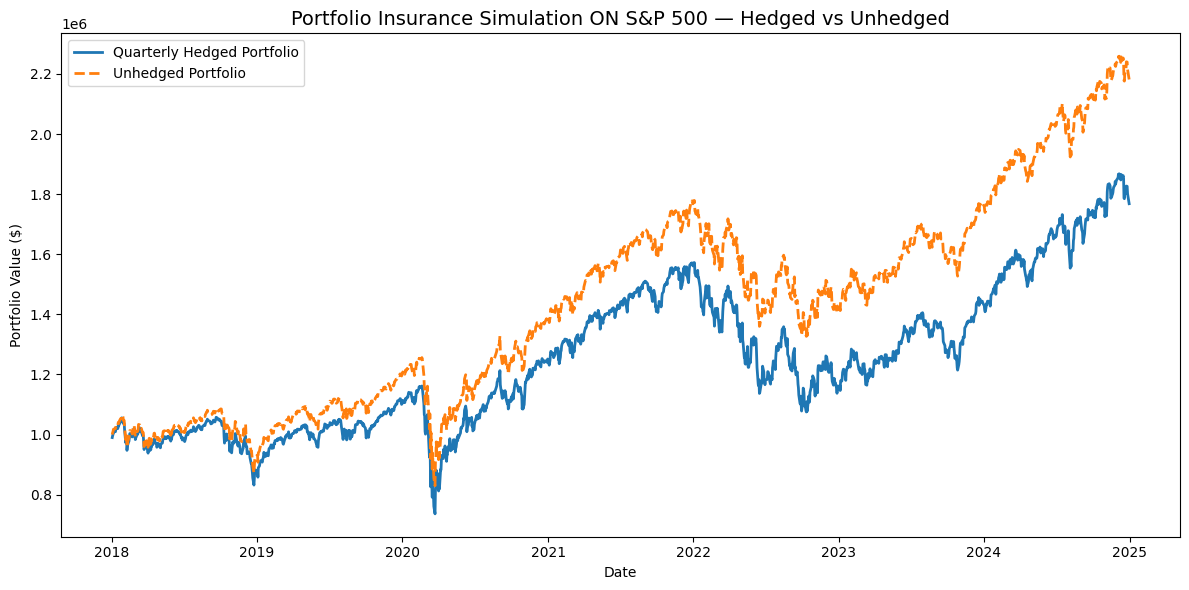

In [ ]:
# --- Create an unhedged benchmark (S&P 500 exposure) ---
unhedged = (portfolio.initial_value * (1 + market.data["Returns"]).cumprod()).rename(
    "Unhedged"
)

# Merge data for consistent dates
merged = pd.merge(results, unhedged, left_on="Date", right_index=True, how="inner")

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(
    merged["Date"], merged["Value"], label="Quarterly Hedged Portfolio", linewidth=2
)
plt.plot(
    merged["Date"],
    merged["Unhedged"],
    label="Unhedged Portfolio",
    linestyle="--",
    linewidth=2,
)
plt.title(
    "Portfolio Insurance Simulation ON S&P 500 — Hedged vs Unhedged",
    fontsize=14,
)
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
final_hedged = merged["Value"].iloc[-1]
final_unhedged = merged["Unhedged"].iloc[-1]
hedged_return = (final_hedged / portfolio.initial_value - 1) * 100
unhedged_return = (final_unhedged / portfolio.initial_value - 1) * 100

print(
    f"Quarterly Hedged Final Value (2018-2025): "
    f"${final_hedged:,.2f} ({hedged_return:.2f}%)"
)
print(
    f"Unhedged Final Value (2018-2025): ${final_unhedged:,.2f} ({unhedged_return:.2f}%)"
)

Quarterly Hedged Final Value (2018-2025): $1,768,290.71 (76.83%)
Unhedged Final Value (2018-2025): $2,181,767.17 (118.18%)


The figure above compares a **quarterly hedged portfolio** with an **unhedged S&P 500 benchmark** from 2018 to 2025.

- **Unhedged Portfolio (orange):** Fully exposed to the market, it captures both the strong post-2020 bull run and the sharp drawdowns during downturns such as the 2020 crash and the 2022 correction.  
  Despite volatility, the unhedged portfolio ultimately delivers the highest cumulative return.

- **Quarterly Hedged Portfolio (blue):** Purchases new put options every 90 days regardless of market conditions.  
  This constant protection comes at a steep cost — the portfolio spends money on insurance even during long stable or rising periods.  
  As a result, performance lags meaningfully behind the benchmark, and the return path is **not dramatically smoother**, since frequent option premiums continuously drag on growth.

Overall, the **quarterly hedge proves inefficient**: it reduces returns substantially but does not fully eliminate drawdowns. It illustrates that mechanical, schedule-based hedging can **over-insure the portfolio**, eroding performance without offering proportional risk reduction. More adaptive strategies — such as **conditional or volatility-triggered hedging** — can achieve a better balance between cost and protection.


### Try Conditional Hedging Strategy (Adaptive Protection)
The earlier quarterly hedging strategy purchased put options every 90 days, regardless of market trends. While this provided consistent protection, it also led to **high recurring costs**, even when markets were stable or rising. To make the insurance more cost-effective, we introduce a **conditional hedging strategy** that buys protection **only when risk increases**.

The strategy monitors recent market behavior and triggers a hedge when either of the following conditions occurs:
1. **Significant Price Decline**  
   - If the market drops by more than a specified threshold (e.g., 5%) over the last 20 trading days.  
2. **Volatility Spike**  
   - If short-term volatility (20-day standard deviation of returns) exceeds 1.5× the long-term (1-year) average volatility.

When one of these risk signals appears **and** the portfolio has no active put options, the strategy buys a new protective put:
- **Strike price:** 10% below the current market level (out-of-the-money)  
- **Expiration:** 90 days ahead  
- **Premium:** 1% of the portfolio’s current equity value  

This adaptive rule achieves a more efficient trade-off:
- **Lower cost:** avoids constant spending on unnecessary insurance  
- **Timely protection:** activates only during turbulent or declining markets  
- **Realism:** resembles how institutional investors dynamically adjust hedges based on volatility and market drawdowns

In short, this strategy provides protection *when it’s needed most*, without sacrificing long-term growth through excessive premium costs.

In [ ]:
def conditional_hedging_strategy(
    portfolio, current_price, current_date, params, market
):
    """Adaptive hedging: buy puts only after price drops or volatility spikes."""
    # Parameters
    lookback_days = params.get("lookback_days", 20)
    drop_threshold = params.get("drop_threshold", -0.05)  # 5% drop
    vol_multiplier = params.get("vol_multiplier", 1.5)
    put_cost_ratio = params.get("put_cost", 0.01)
    strike_ratio = params.get("strike_ratio", 0.9)
    expiry_days = params.get("expiry_days", 90)

    # Ensure sufficient history
    past_data = market.data.loc[:current_date].tail(252)  # last year
    recent_data = market.data.loc[:current_date].tail(lookback_days)

    if len(recent_data) < lookback_days or len(past_data) < 50:
        return  # skip early period

    # Compute recent return and volatility
    recent_return = float(
        recent_data["Close"].iloc[-1] / recent_data["Close"].iloc[0] - 1
    )
    recent_vol = float(recent_data["Returns"].std())
    long_term_vol = float(past_data["Returns"].std())

    price_drop_trigger = recent_return <= drop_threshold
    vol_spike_trigger = recent_vol > vol_multiplier * long_term_vol
    risk_trigger = bool(price_drop_trigger or vol_spike_trigger)

    # Active hedge check
    active_puts = [
        opt
        for opt in portfolio.options
        if pd.Timestamp(opt.expiry) > pd.Timestamp(current_date)
    ]

    if risk_trigger and not active_puts:
        strike = current_price * strike_ratio
        premium = portfolio.equity_value * put_cost_ratio
        expiry = current_date + timedelta(days=expiry_days)
        portfolio.buy_put(strike, premium, expiry, quantity=1)


params = {
    "lookback_days": 20,
    "drop_threshold": -0.05,
    "vol_multiplier": 1.5,
    "put_cost": 0.01,
    "strike_ratio": 0.9,
    "expiry_days": 90,
}

/var/folders/2r/ndfjf2qs2vq5tcc5nmz1qjw00000gn/T/ipykernel_69259/171227985.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  recent_return = float(recent_data["Close"].iloc[-1] / recent_data["Close"].iloc[0] - 1)


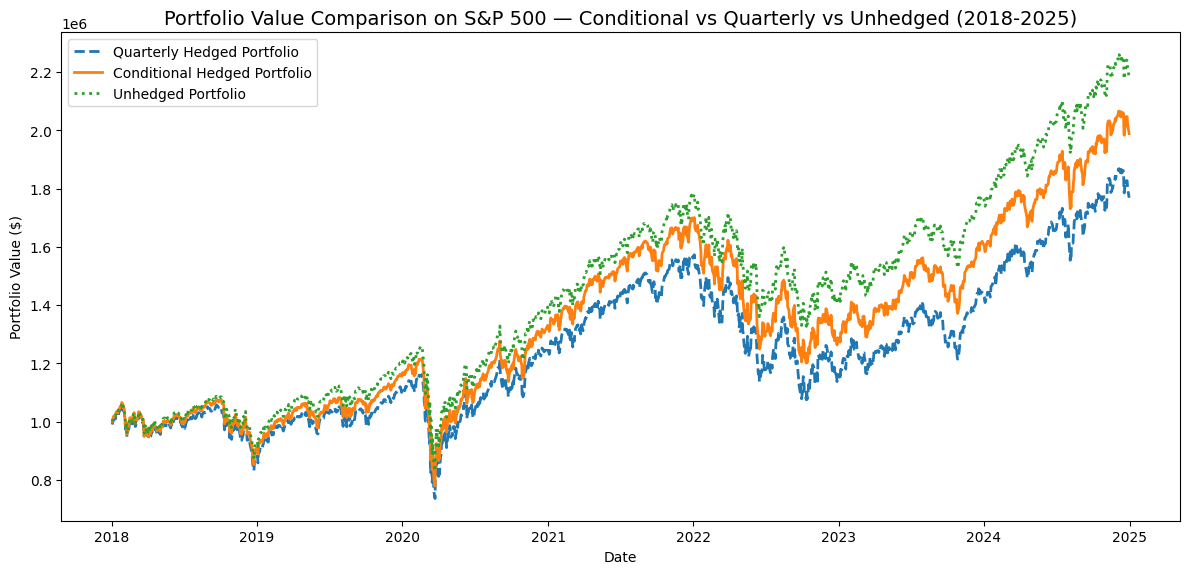

In [ ]:
# Re-initialize for clean, independent runs
portfolio_unhedged = Portfolio(initial_value=1_000_000, beta=1.0)
portfolio_quarterly = Portfolio(initial_value=1_000_000, beta=1.0)
portfolio_conditional = Portfolio(initial_value=1_000_000, beta=1.0)

# Run each strategy independently
results_quarterly = run_simulation(
    market,
    portfolio_quarterly,
    quarterly_protective_put_strategy,
    params,
)
results_conditional = run_simulation(
    market,
    portfolio_conditional,
    conditional_hedging_strategy,
    params,
)

# Unhedged baseline (no strategy applied)
unhedged = (
    portfolio_unhedged.initial_value * (1 + market.data["Returns"]).cumprod()
).rename("Unhedged")

merged_all = pd.merge(
    results_quarterly,
    results_conditional,
    on="Date",
    suffixes=("_Quarterly", "_Conditional"),
)
merged_all = pd.merge(
    merged_all,
    unhedged,
    left_on="Date",
    right_index=True,
    how="inner",
)

plt.figure(figsize=(12, 6))
plt.plot(
    merged_all["Date"],
    merged_all["Value_Quarterly"],
    label="Quarterly Hedged Portfolio",
    linestyle="--",
    linewidth=2,
)
plt.plot(
    merged_all["Date"],
    merged_all["Value_Conditional"],
    label="Conditional Hedged Portfolio",
    linewidth=2,
)
plt.plot(
    merged_all["Date"],
    merged_all["Unhedged"],
    label="Unhedged Portfolio",
    linestyle=":",
    linewidth=2,
)
plt.title(
    "Portfolio Value Comparison on S&P 500 — "
    "Conditional vs Quarterly vs Unhedged (2018-2025)",
    fontsize=14,
)
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
initial_value = 1_000_000

final_quarterly = merged_all["Value_Quarterly"].iloc[-1]
final_conditional = merged_all["Value_Conditional"].iloc[-1]
final_unhedged = merged_all["Unhedged"].iloc[-1]

quarterly_return = (final_quarterly / initial_value - 1) * 100
conditional_return = (final_conditional / initial_value - 1) * 100
unhedged_return = (final_unhedged / initial_value - 1) * 100

# --- Print Comparison ---
print("Portfolio Performance Comparison (2018–2025)")
print("----------------------------------------------------")
print(
    f"Quarterly Hedged Final Value: ${final_quarterly:,.2f} ({quarterly_return:.2f}%)"
)
print(
    f"Conditional Hedged Final Value: ${final_conditional:,.2f} "
    f"({conditional_return:.2f}%)"
)
print(f"Unhedged Final Value: ${final_unhedged:,.2f} ({unhedged_return:.2f}%)")

Portfolio Performance Comparison (2018–2025)
----------------------------------------------------
Quarterly Hedged Final Value: $1,768,290.71 (76.83%)
Conditional Hedged Final Value: $1,988,241.82 (98.82%)
Unhedged Final Value: $2,181,767.17 (118.18%)


The figure above compares three portfolios over the 2018–2025 period:  
a **Quarterly Hedged Portfolio** (blue dashed), a **Conditional Hedged Portfolio** (orange), and an **Unhedged Portfolio** (green dotted).

- **Unhedged Portfolio (green dotted):** Achieves the highest long-term return by remaining fully exposed to market risk. However, it also experiences significant drawdowns during crises (e.g., early 2020, 2022 corrections).  

- **Quarterly Hedged Portfolio (blue dashed):** Underperforms across the board. Frequent and fixed purchases of put options consume capital even when markets are calm or rising. This results in **lower returns without a proportionate reduction in volatility**.

- **Conditional Hedged Portfolio (orange):** Strikes a better balance. By buying protection only when prices drop or volatility spikes, it avoids wasting money on unnecessary hedges. The result is **higher returns than the quarterly hedge** and **smoother drawdowns** than the unhedged case.

Overall, The **conditional (smart) hedge** clearly outperforms the quarterly approach by being more selective and cost-efficient. It provides protection when it matters—during turbulent markets—while preserving growth during stable or bullish periods. In contrast, the **quarterly hedge proves too rigid and expensive**, highlighting the value of **adaptive, data-driven risk management** over static insurance schedules.
